In [1]:
from utils import add_noise, model_params, smooth, save_model, load_model, set_random_seed, TripletLoss, visualize_progress, display_projections, Trainer, UnNormalize

In [3]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torchvision import models

from torch.utils.tensorboard import SummaryWriter

2.0.1+cu118


In [4]:
#from utils import eval_model, train, smooth, save_model, load_model, model_params, eval_plots, set_random_seed, eval_model_conf

In [5]:
# choose device to be used depending on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!mkdir data
!cp /content/drive/MyDrive/Market-1501-v15.09.15.zip /content/data/

In [8]:
!unzip -q -d data data/Market-1501-v15.09.15.zip

In [10]:
from dataset_utils import Market1501, TripletDataset

In [11]:
train_transforms = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.486, 0.459, 0.408), (0.229, 0.224, 0.225)),
            ])

test_transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.486, 0.459, 0.408), (0.229, 0.224, 0.225)),
                ])


pre_train_dataset = Market1501('/content/data/Market-1501-v15.09.15/bounding_box_train', transforms = train_transforms)
pre_test_dataset = Market1501('/content/data/Market-1501-v15.09.15/bounding_box_test', transforms = test_transforms)

In [14]:
train_dataset = TripletDataset(pre_train_dataset)
test_dataset = TripletDataset(pre_test_dataset)
val_dataset = test_dataset#TripletDataset(pre_val_dataset)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 12936
Test samples: 19732
Validation samples: 19732


Some example images

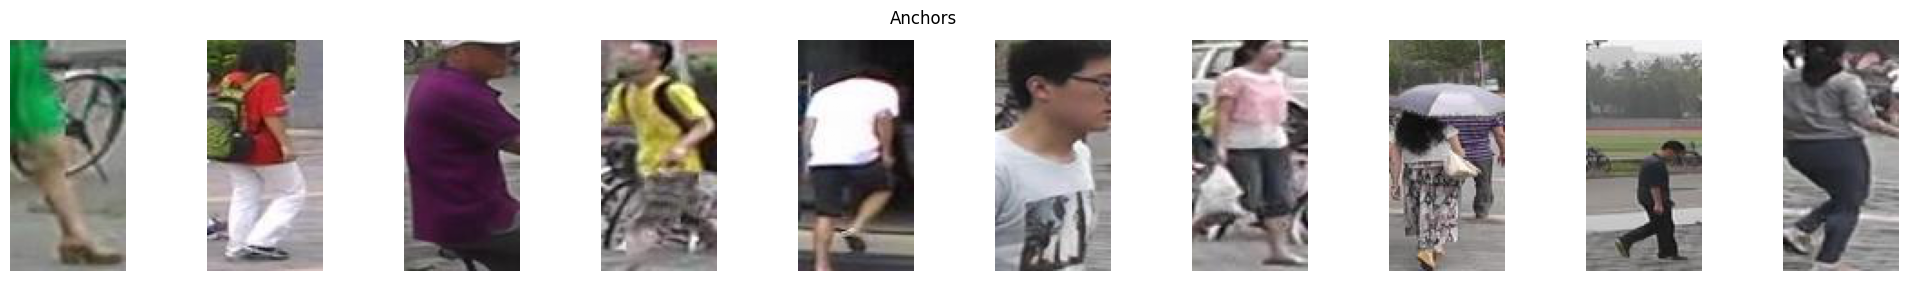

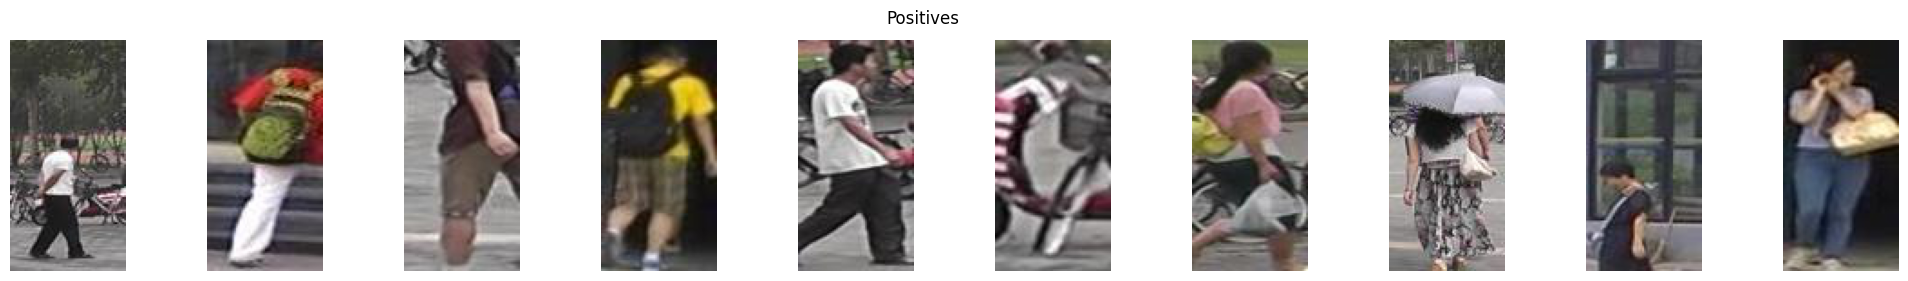

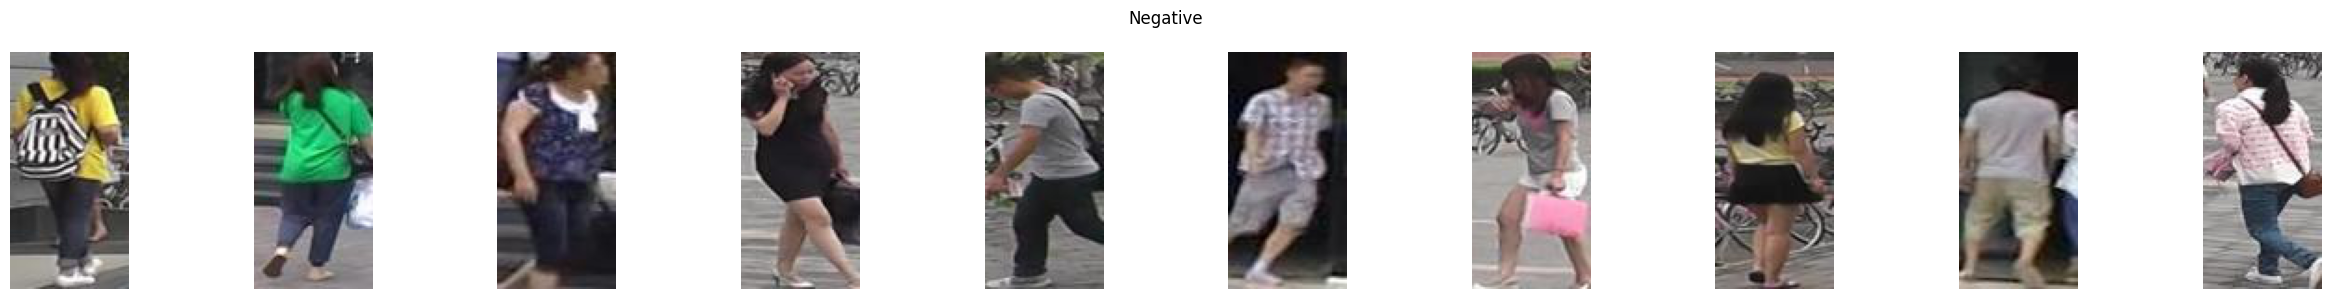

In [15]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(25,3))
fig_pos, positives = plt.subplots(1, 10, figsize=(25,3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(25,3))
for i in range(10):
    (anchor, positive, negative), _ = val_dataset[i+6]
    anchors[i].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(anchor).permute(1,2,0))
    anchors[i].axis("off")
    positives[i].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(positive).permute(1,2,0))
    positives[i].axis("off")
    negatives[i].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(negative).permute(1,2,0))
    negatives[i].axis("off")
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### Define TriSiamese models for learning

In [19]:
from model import AdpSiameseModel

model = AdpSiameseModel(emb_dim=512, pretrained = True, fine_tune = True)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


AdpSiameseModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [20]:
print(f"The generator has {model_params(model)} parameters.")

The generator has 525312 parameters.


### definition of learning parameters and training

In [21]:
criterion = TripletLoss(margin=0.2)

In [22]:
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=10000)

In [23]:
import time
set_random_seed(420)
start_time = time.time()
trainer.fit()
print("--- %s seconds ---" % (time.time() - start_time))

Train Iter 9999 | Epoch 49: Loss=0.00645 | Valid loss=0.12754180769223977 (per 250 it): 100%|██████████| 10000/10000 [48:35<00:00,  3.43it/s]

--- 2915.823566198349 seconds ---


### some training stats

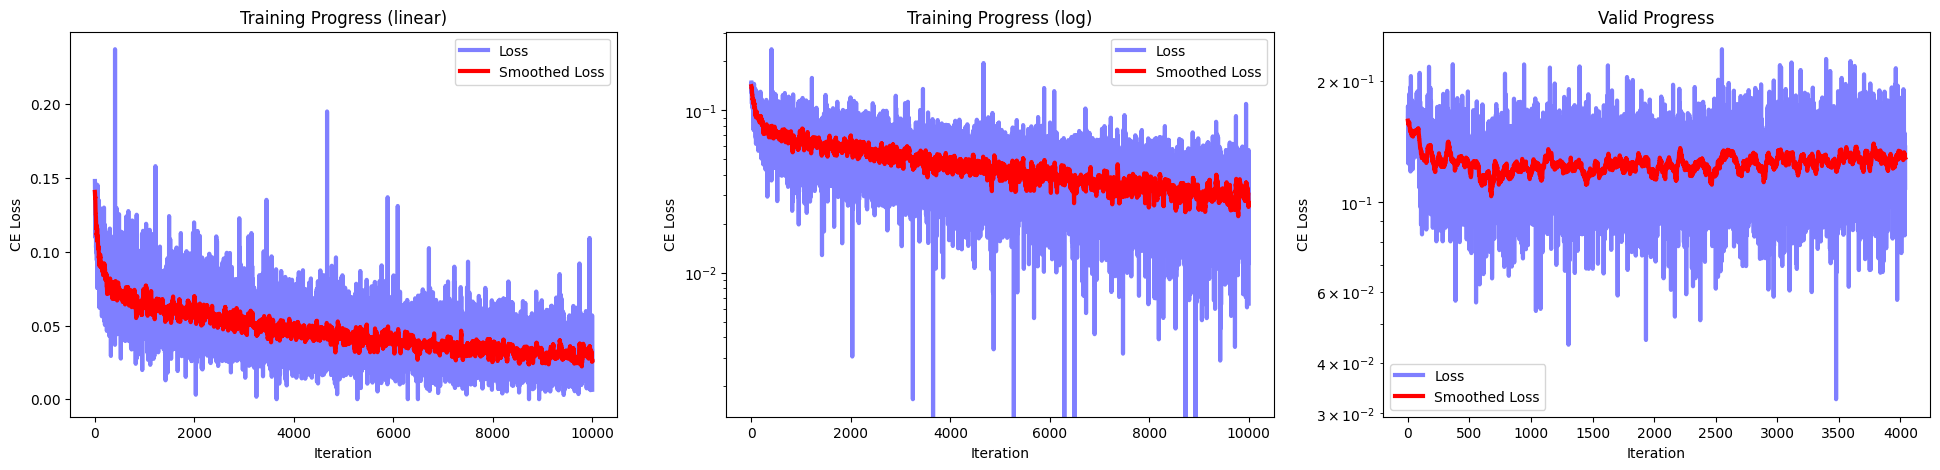

In [24]:
visualize_progress(trainer.train_loss, trainer.valid_loss, start=0)

The training loss decreases steadily and converges. The validation loss decreases sharply in the beginning, but stays the same after about 500 iterations. Here the loss decreases slower compared to the finetuned model, and the final loss is also higher.

### performance on full test set

In [26]:
set_random_seed(42) # always use same random seed to ensure comparability between models
full_loss, pred, true_val = trainer.valid_step(val_iters=len(test_dataset), get_res = True)
print(f"The full loss on the train set is {full_loss[0]}.")

The full loss on the train set is 0.13472720980644226.


The loss over the whole training set is slightly higher than the loss with the fine tuned model (0.130 vs 0.134) Therefore the other model is slightly better. (It is supposed to say test loss)

In [27]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(true_val, pred) # we use auc instead of accuracy as we do not want to set a threshold manually (could strongly influence results)
                                    # instead now we see how well individuals are separated/close together

print(f"AUC = {auc}.")

AUC = 0.7690727756806399.


We use area under curve for ROC as a general performance metric, as we do not have to choose a threshold manually. Here the AUS value is lower compared to the completely trained model. Therefore the other model has a better result.

### embeddings

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [29]:
model = model.eval()

In [30]:
(img,_,_),(lbl,_,_) = next(iter(test_loader))

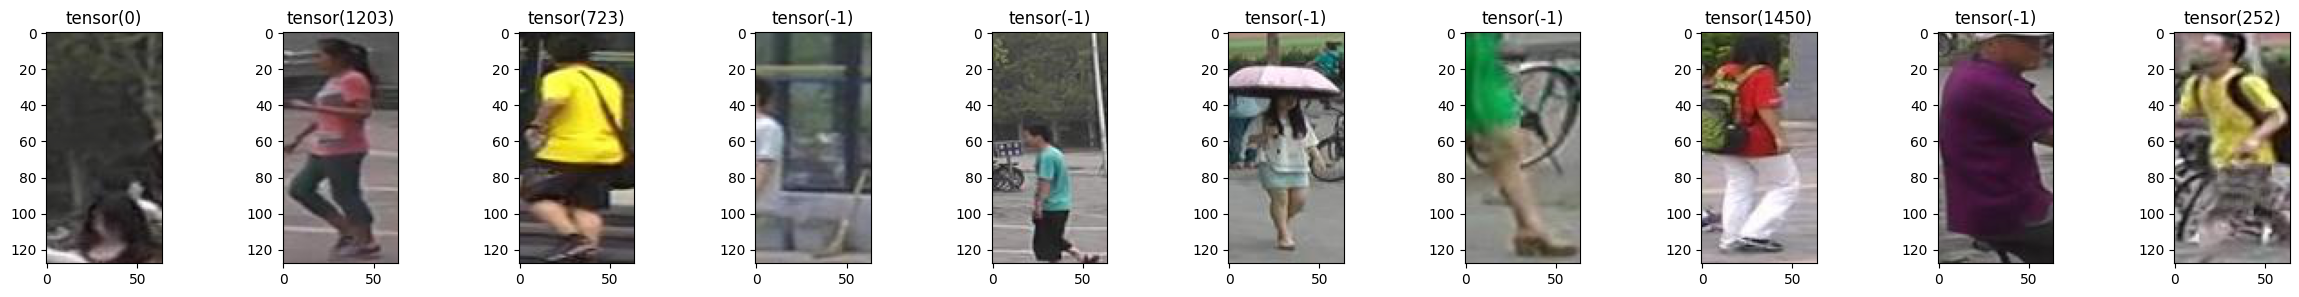

In [31]:
fig, ax = plt.subplots(1,10, figsize=(30,3))
for i in range(10):
    ax[i].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(img[i]).permute(1,2,0))
    ax[i].set_title(lbl[i])

In [32]:
embs = []
labels = []
with torch.no_grad():
    for (anchor, _, _), (lbl,_, _) in test_loader:
        anchor = anchor.to(device)
        anchor_emb = model.forward_one(anchor)

        labels.append(lbl)
        embs.append(anchor_emb.cpu())

labels = np.concatenate(labels)
embs = np.concatenate(embs)

In [33]:
pca_embs = PCA(n_components=2).fit_transform(embs)

In [34]:
k = 25 # use 25 'random' classes for diagrams (with more classes colors get mixed up)
labels_to_keep = list(np.unique(labels)[23:k+23]) # keep first n labels for plotting (+1 to not keep 'noise images')
N = 5000

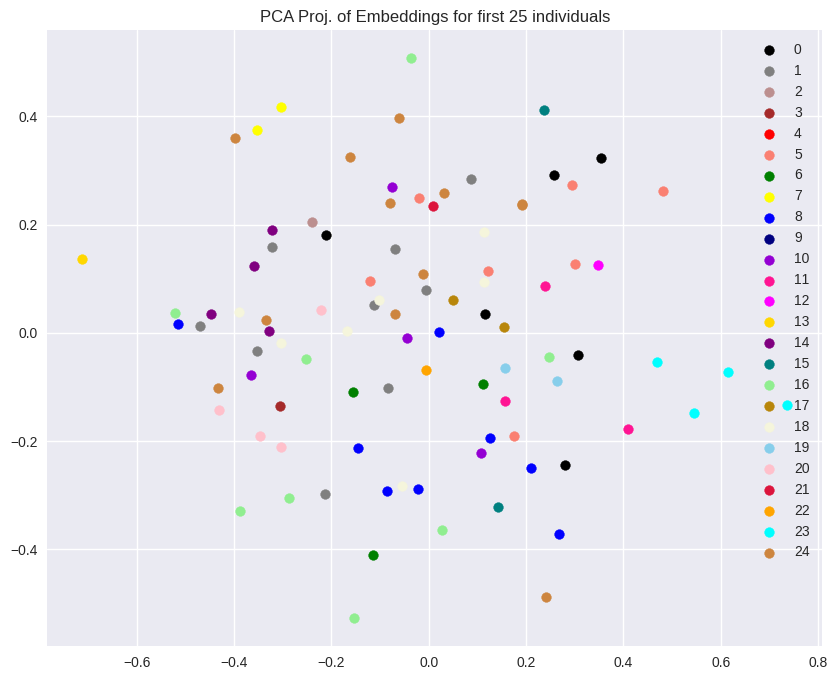

In [35]:
plt.style.use('seaborn-v0_8')
fig,ax = plt.subplots(1,1,figsize=(10,8))
display_projections(pca_embs[:N], labels[:N], ax=ax, labels_to_keep = labels_to_keep)
ax.set_title(f"PCA Proj. of Embeddings for first {k} individuals")
plt.show()


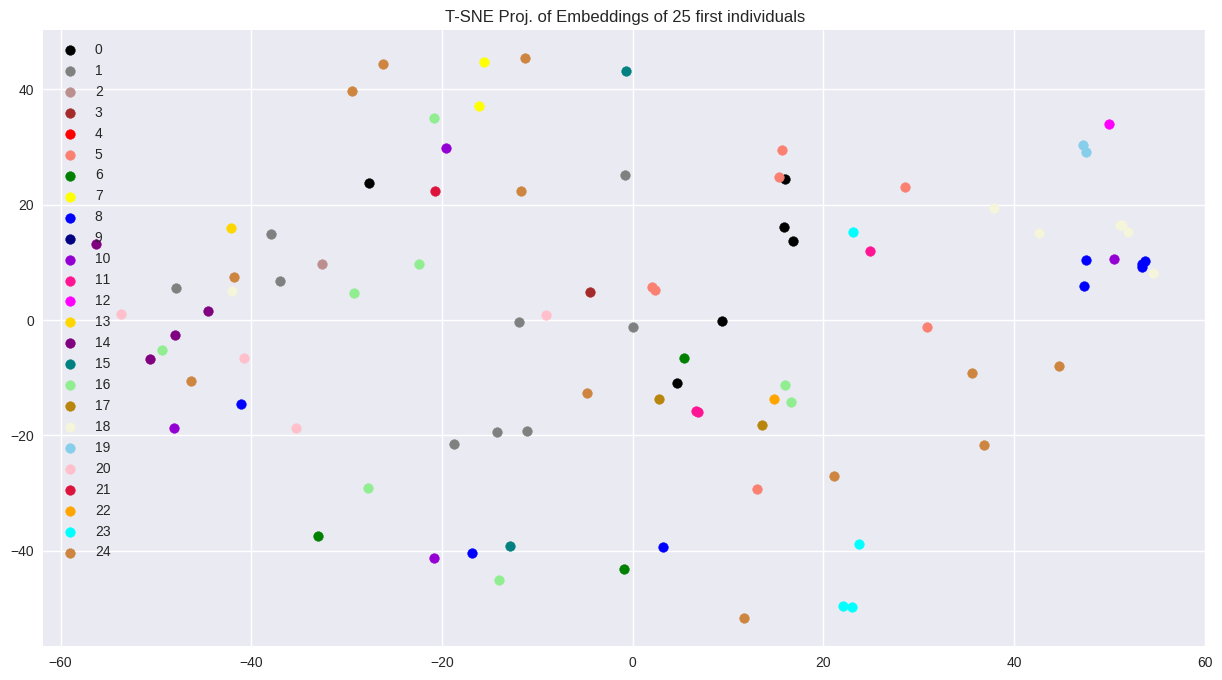

In [36]:
tsne_embs = TSNE(n_components=2).fit_transform(embs[:N])

fig,ax = plt.subplots(1,1,figsize=(15,8))
display_projections(tsne_embs[:N], labels[:N], ax=ax, labels_to_keep = labels_to_keep)
ax.set_title(f"T-SNE Proj. of Embeddings of {k} first individuals")
plt.show()

In both diagrams above no clear separation between the choosen 25 classes for visualization is observable. No clusters are observable. The diagrams seem to look similar to simple noise (this is also the case for other choosen classes).

### Clustering

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [38]:
kmeans_embs = KMeans(n_clusters=len(np.unique(labels[:2500])), random_state=0).fit(embs[:2500])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [39]:
ari_embs = adjusted_rand_score(labels[:2500], kmeans_embs.labels_)

In [40]:
print(f"Clustering embeddings achieves ARI={round(ari_embs*100,2)}%")

Clustering embeddings achieves ARI=0.23%


When the model is only finetuned the ARI score is much lower compared to training the full model with 0.23% to 0.84%. However both values are low. Differnt indiviuals are probably not moved far away from each other as there are many individuals with sometimes only a low number of instances per individual.

some examples

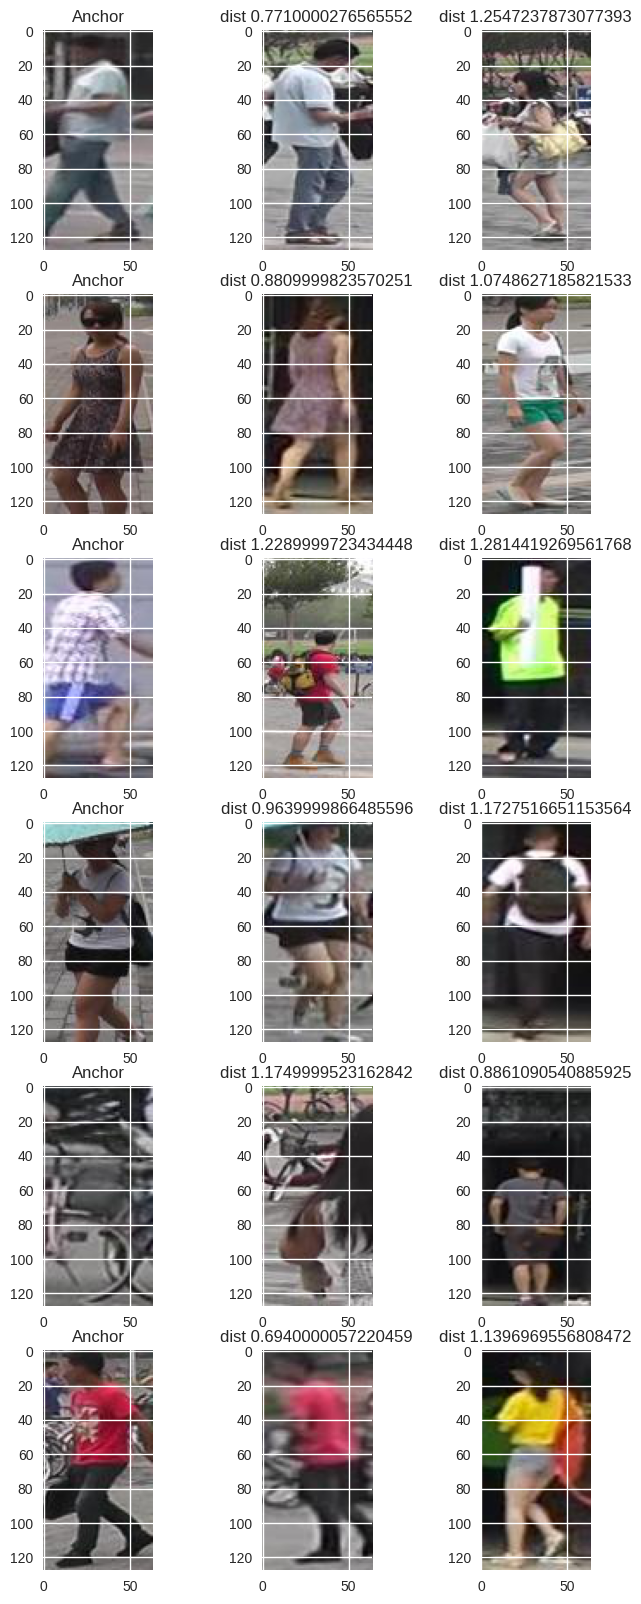

In [51]:
n_img = 6

fig,ax = plt.subplots(n_img,3,figsize=(8,20))


for i in range(n_img):
  item, _ = test_dataset[i+345]

  embs = model(item[0].to(device).reshape(1,3,128,64), item[1].to(device).reshape(1,3,128,64), item[2].to(device).reshape(1,3,128,64))

  d_p = torch.sqrt((embs[0] - embs[1]).pow(2).sum(dim=-1)).detach().cpu().numpy()
  d_n = torch.sqrt((embs[0] - embs[2]).pow(2).sum(dim=-1)).detach().cpu().numpy()

  ax[i,0].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(item[0]).permute(1,2,0))
  ax[i,0].set_title('Anchor')
  ax[i,1].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(item[1]).permute(1,2,0))
  ax[i,1].set_title(f"dist {round(d_p[0],3)}")
  ax[i,2].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(item[2]).permute(1,2,0))
  ax[i,2].set_title(f"dist {d_n[0]}")


In the images above are some images compared to images of the same individual and a random other individual with the distances compared to the anchor image. The calculated values seem to make sense, where persons that can be reidentified by a human (here us) have a lower distance and individuals that look much better have a much bigger distance. However these distances are not that far apart (compared to the model where the full model is trained)